<a href="https://colab.research.google.com/github/martinsria7/EnviroML-XAI/blob/main/Alzheimer's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports and setup

!pip install shap xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

shap.initjs()
np.random.seed(42)

In [2]:
# Load data
merged_dataset = pd.read_csv(
    '/content/Alzheimer_merged.csv',
    encoding='ISO-8859-1'
)

X = merged_dataset.drop(columns=['AD_PREV_MEAN'])
y = merged_dataset['AD_PREV_MEAN']


In [3]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
# One-hot encoding
non_numeric_columns = X_train.select_dtypes(include=['object', 'category']).columns

combined = pd.concat([X_train, X_test], keys=['train', 'test'])
combined_encoded = pd.get_dummies(combined, columns=non_numeric_columns)

X_train_encoded = combined_encoded.xs('train')
X_test_encoded = combined_encoded.xs('test')

In [ ]:
# Hyperparameter tuning (Grid Search)
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1
)

grid_search.fit(X_train_encoded, y_train.values.ravel())

model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
# Model evaluation
y_pred = model.predict(X_test_encoded)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
nrmse = rmse / (y_test.max() - y_test.min())

print("\nModel performance on test set:")
print(f"RMSE:  {rmse:.4f}")
print(f"MAE:   {mae:.4f}")
print(f"R²:    {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")


Model performance on test set:
RMSE:  0.8277
MAE:   0.5896
R²:    0.6961
NRMSE: 0.0774


In [ ]:
# Recursive Feature Elimination (Top 15)
selector = RFE(
    estimator=model,
    n_features_to_select=15
)

selector.fit(X_train_encoded, y_train.values.ravel())

selected_features = X_train_encoded.columns[selector.support_]
print("\nTop 15 selected features:")
print(selected_features)

X_train_selected = X_train_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]

# Refit model on selected features
model.fit(X_train_selected, y_train.values.ravel())


In [ ]:
# SHAP analysis

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_selected)

In [ ]:
# County-level most important variable
shap_df = pd.DataFrame(
    np.abs(shap_values),
    columns=X_train_selected.columns,
    index=X_test_selected.index
)

most_important_feature = shap_df.idxmax(axis=1)
max_shap_value = shap_df.max(axis=1)

output_df = pd.DataFrame({
    'FIPS': merged_dataset.loc[shap_df.index, 'FIPS'],
    'Most_Important_Variable': most_important_feature,
    'SHAP_Value': max_shap_value
})

output_df.to_csv(
    'AD_MostImportantVariablePerCounty.csv',
    index=False
)

print("\nSaved: AD_MostImportantVariablePerCounty.csv")

In [ ]:
mean_shap_values = shap_df.mean().sort_values(ascending=False)

In [ ]:
# SHAP bar plot

plt.rcParams.update({
    'font.size': 22,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.labelsize': 22,
    'axes.titlesize': 24,
    'xtick.labelsize': 18,
    'ytick.labelsize': 22,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.linewidth': 1.2
})

fig, ax = plt.subplots(figsize=(14, 11))

ax.barh(
    mean_shap_values.index,
    mean_shap_values.values,
    color="#5B9BD5",
    edgecolor="white"
)

for i, v in enumerate(mean_shap_values.values):
    ax.text(
        v + 0.005,
        i,
        f"{v:.3f}",
        va='center',
        ha='left',
        fontsize=18,
        fontweight='bold'
    )

ax.set_xlabel("Mean |SHAP value|")
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(
    'publication_style_SHAP.png',
    bbox_inches='tight',
    facecolor='white'
)
plt.show()

# Reset defaults
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Top predictors from SHAP
top_features = [
    "Chloride_precipitation",
    "Median_household_value",
    "Families_in_poverty",
    "Nitrate_precipitation",
    "Sulfate_precipitation"
]

fig, ax = plt.subplots(figsize=(16, 12))

PartialDependenceDisplay.from_estimator(
    model,
    X_train_selected,
    features=top_features,
    kind="average",
    grid_resolution=50,
    ax=ax
)

plt.suptitle(
    "Partial Dependence of Key Predictors on Alzheimer's Disease Prevalence",
    fontsize=20
)

plt.tight_layout()
plt.savefig("Figure_PDP_MainEffects.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
interaction_pairs = [
    ("Chloride_precipitation", "Families_in_poverty"),
    ("Chloride_precipitation", "Median_household_value"),
    ("Nitrate_precipitation", "Sulfate_precipitation")
]

fig, ax = plt.subplots(1, 3, figsize=(22, 6))

PartialDependenceDisplay.from_estimator(
    model,
    X_train_selected,
    features=interaction_pairs,
    kind="average",
    grid_resolution=30,
    ax=ax
)

plt.suptitle(
    "Two-Way Partial Dependence Showing Nonlinear Interactions",
    fontsize=22
)

plt.tight_layout()
plt.savefig("Figure_PDP_Interactions.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
!pip install pygam


In [ ]:
from pygam import LinearGAM, s, te


In [ ]:
# Use same top predictors
gam_features = [
    "Chloride_precipitation",
    "Median_household_value",
    "Families_in_poverty",
    "Nitrate_precipitation",
    "Sulfate_precipitation"
]

X_gam = X_train_selected[gam_features].values
y_gam = y_train.values.ravel()

gam = LinearGAM(
    s(0, n_splines=20) +
    s(1, n_splines=20) +
    s(2, n_splines=20) +
    s(3, n_splines=20) +
    s(4, n_splines=20)
).fit(X_gam, y_gam)


In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(14, 16))
axs = axs.flatten()

for i, feature in enumerate(gam_features):
    XX = gam.generate_X_grid(term=i)
    axs[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    axs[i].plot(
        XX[:, i],
        gam.partial_dependence(term=i, X=XX, width=0.95)[1],
        linestyle="--"
    )
    axs[i].set_title(feature)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Partial effect on AD prevalence")

plt.tight_layout()
plt.savefig("Figure_GAM_MainEffects.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
gam_interact = LinearGAM(
    te(0, 2, n_splines=15) +  # Chloride × Poverty
    s(1) + s(3) + s(4)
).fit(X_gam, y_gam)


In [ ]:
fig = plt.figure(figsize=(7, 6))
XX = gam_interact.generate_X_grid(term=0)

Z = gam_interact.partial_dependence(term=0, X=XX)
X1 = XX[:, 0].reshape(30, 30)
X2 = XX[:, 2].reshape(30, 30)
Z = Z.reshape(30, 30)

ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X1, X2, Z, cmap="viridis")

ax.set_xlabel("Chloride precipitation")
ax.set_ylabel("Families in poverty")
ax.set_zlabel("Effect on AD prevalence")

plt.savefig("Figure_GAM_Interaction.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# SHAP Dependence Plots for Top Features (NEW - addresses reviewer)
top_features = ['ChloridePrecipitation_mm', 'MedianHouseholdValue', '%families_poverty']  # Update with YOUR top 3 names

plt.rcParams.update({'font.size': 16, 'figure.dpi': 300})

for i, feature in enumerate(top_features):
    plt.figure(figsize=(10, 6))

    # PDP with automatic interaction detection
    shap.dependence_plot(feature, shap_values.values, X_test_selected,
                        show=False, feature_values=X_test_selected[feature])

    plt.title(f'SHAP Dependence Plot: {feature}', fontsize=18, fontweight='bold')
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('SHAP Value (Impact on AD Prediction)', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'SHAP_PDP_{feature.replace("%", "pct").replace("/", "_")}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

# 2-feature interaction PDP (chloride + poverty - KEY for reviewer)
shap.dependence_plot('ChloridePrecipitation_mm', shap_values.values, X_test_selected,
                    interaction_index='%families_poverty',
                    show=False, feature_values=X_test_selected['ChloridePrecipitation_mm'])
plt.title('Chloride Precipitation Interaction with Poverty', fontsize=18, fontweight='bold')
plt.savefig('SHAP_PDP_Chloride_Poverty_Interaction.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
interaction_pairs = [
    ("Chloride_precipitation", "Families_in_poverty"),
    ("Chloride_precipitation", "Median_household_value"),
    ("Nitrate_precipitation", "Sulfate_precipitation")
]

fig, ax = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(22, 6),
    subplot_kw={"projection": "3d"}
)

PartialDependenceDisplay.from_estimator(
    model,
    X_train_selected,
    features=interaction_pairs,
    kind="average",
    grid_resolution=30,
    ax=ax
)

plt.suptitle(
    "Two-Way Partial Dependence Showing Nonlinear Interactions\nBetween Environmental and Socioeconomic Factors",
    fontsize=22
)

plt.tight_layout()
plt.show()


In [ ]:
explainer = shap.TreeExplainer(model)
shap_interaction_values = explainer.shap_interaction_values(X_test_selected)

# Summary of interactions
shap.summary_plot(
    shap_interaction_values,
    X_test_selected,
    max_display=10
)


In [ ]:
shap.dependence_plot(
    ("Chloride_precipitation", "Families_in_poverty"),
    shap_interaction_values,
    X_test_selected
)


In [ ]:
non_numeric_columns = X_train.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_columns)

combined = pd.concat([X_train, X_test], keys=['train', 'test'])
combined_encoded = pd.get_dummies(combined, columns=non_numeric_columns)
X_train_encoded = combined_encoded.xs('train')
X_test_encoded = combined_encoded.xs('test')

Non-numeric columns: Index(['Counties'], dtype='object')


In [ ]:
from sklearn.metrics import mean_squared_error

model = XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train.values.ravel())

cv_scores = cross_val_score(model, X_train_encoded, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-Validation RMSE Scores:", cv_rmse)
print("Mean RMSE:", cv_rmse.mean())

y_pred = model.predict(X_test_encoded)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
range_y_test = y_test.max() - y_test.min()
nrmse_test = rmse_test / range_y_test
print("Test RMSE:", rmse_test)
print("Test Normalized RMSE:", nrmse_test)

Cross-Validation RMSE Scores: [0.87433004 1.0304864  0.98882246 0.91128325 0.90867232]
Mean RMSE: 0.9427188962493661
Test RMSE: 0.8969972424828393
Test Normalized RMSE: 0.0838315179890504


In [ ]:
# Fit model
model.fit(X_train_encoded, y_train.values.ravel())

selector = RFE(model, n_features_to_select=15)
selector.fit(X_train_encoded, y_train.values.ravel())

selected_features = X_train_encoded.columns[selector.support_]
print("Top 15 Selected Features:", selected_features)


Top 15 Selected Features: Index(['% Families in poverty', 'Median household value',
       'Median household income', '% Renter occupied units',
       'Violent crime rate ', 'Potassium precipitation ',
       'Nitrate precipitation', 'Chloride precipitation ',
       'Sulfate precipitation', '% Extreme drought', 'Cyanide ', 'Nitrate',
       'Simazine ', 'Dinoseb ', 'Benzo(a)pyrene  '],
      dtype='object')


In [ ]:
# Extract only the selected features from train and test sets
X_train_selected = X_train_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]

# Refit the model on the selected features for accurate interpretation
model.fit(X_train_selected, y_train.values.ravel())

# Initialize SHAP TreeExplainer with the trained model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set with selected features
shap_values = explainer.shap_values(X_test_selected)

In [ ]:
shap_df = pd.DataFrame(np.abs(shap_values), columns=X_train_selected.columns)  # Use exactly the columns passed to SHAP

most_important_feature = shap_df.idxmax(axis=1)
max_shap_value = shap_df.max(axis=1)

# Ensure the index of the data matches merged_dataset's index or 'FIPS'
output_df = pd.DataFrame({
    'FIPS': merged_dataset.loc[shap_df.index, 'FIPS'],  # use the same index as SHAP data
    'Most_Important_Variable': most_important_feature,
    'SHAP_Value': max_shap_value
})

output_df.to_csv('AD_MostImportantVariablePerCounty.csv', index=False)
print("✅ AD_MostImportantVariablePerCounty.csv")

NameError: name 'shap_values' is not defined

In [ ]:
# Compute mean absolute SHAP values (descending order)
mean_shap_values = pd.DataFrame(np.abs(shap_values_selected), columns=X_full_selected.columns).mean().sort_values(ascending=False)

plt.rcParams.update({
    'font.size': 22,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.labelsize': 22,
    'axes.titlesize': 24,
    'xtick.labelsize': 18,
    'ytick.labelsize': 22,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.linewidth': 1.2,
    'lines.linewidth': 2
})

fig, ax = plt.subplots(figsize=(14, 11), dpi=300)
bars = ax.barh(mean_shap_values.index, mean_shap_values.values, color="#5B9BD5", edgecolor='white', height=0.8)  # Custom color

# Annotate each bar with value (aligned right, bold)
for idx, value in enumerate(mean_shap_values.values):
    ax.text(value + 0.005, idx, f"{value:.3f}",
            va='center', ha='left',
            fontsize=18, fontweight='bold', color='#37597A')

ax.set_xlabel("Mean |SHAP value|", fontsize=22)
ax.invert_yaxis()  # Highest value at top
ax.xaxis.set_tick_params(length=6, width=1.2)  # Thicker ticks
ax.yaxis.set_tick_params(length=0)  # No tick marks

# Remove top/right spines for minimal style
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_facecolor('white')
plt.tight_layout()

plt.savefig('publication_style.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Reset to matplotlib defaults for future plots
plt.rcParams.update(plt.rcParamsDefault)


NameError: name 'shap_values_selected' is not defined

In [ ]:
import matplotlib.pyplot as plt
import shap

def setup_plot_params(font_size=16, font_weight='bold',
                     label_weight='bold', title_weight='bold',
                     title_size=20, figure_title_size=20,
                     figure_title_weight='bold'):
    """Set up matplotlib parameters for consistent plotting."""
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.weight'] = font_weight
    plt.rcParams['axes.labelweight'] = label_weight
    plt.rcParams['axes.titleweight'] = title_weight
    plt.rcParams['figure.titlesize'] = figure_title_size
    plt.rcParams['figure.titleweight'] = figure_title_weight

def reset_plot_params():
    """Reset matplotlib parameters to default."""
    plt.rcParams.update(plt.rcParamsDefault)

def plot_shap_bar(shap_values, features, figsize=(14, 10), title="Global Feature Importance"):
    """Create a SHAP bar plot for feature importance."""
    plt.figure(figsize=figsize)
    shap.summary_plot(shap_values, features, plot_type="bar", show=False)

    # Enhance the plot appearance
    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.xlabel("Mean |SHAP Value|", fontsize=16, fontweight='bold')
    plt.tight_layout()

    return plt

def plot_shap_summary(shap_values, features, figsize=(12, 8), title="SHAP Summary Plot"):
    """Create a SHAP summary plot."""
    plt.figure(figsize=figsize)
    shap.summary_plot(shap_values, features, show=False)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    return plt

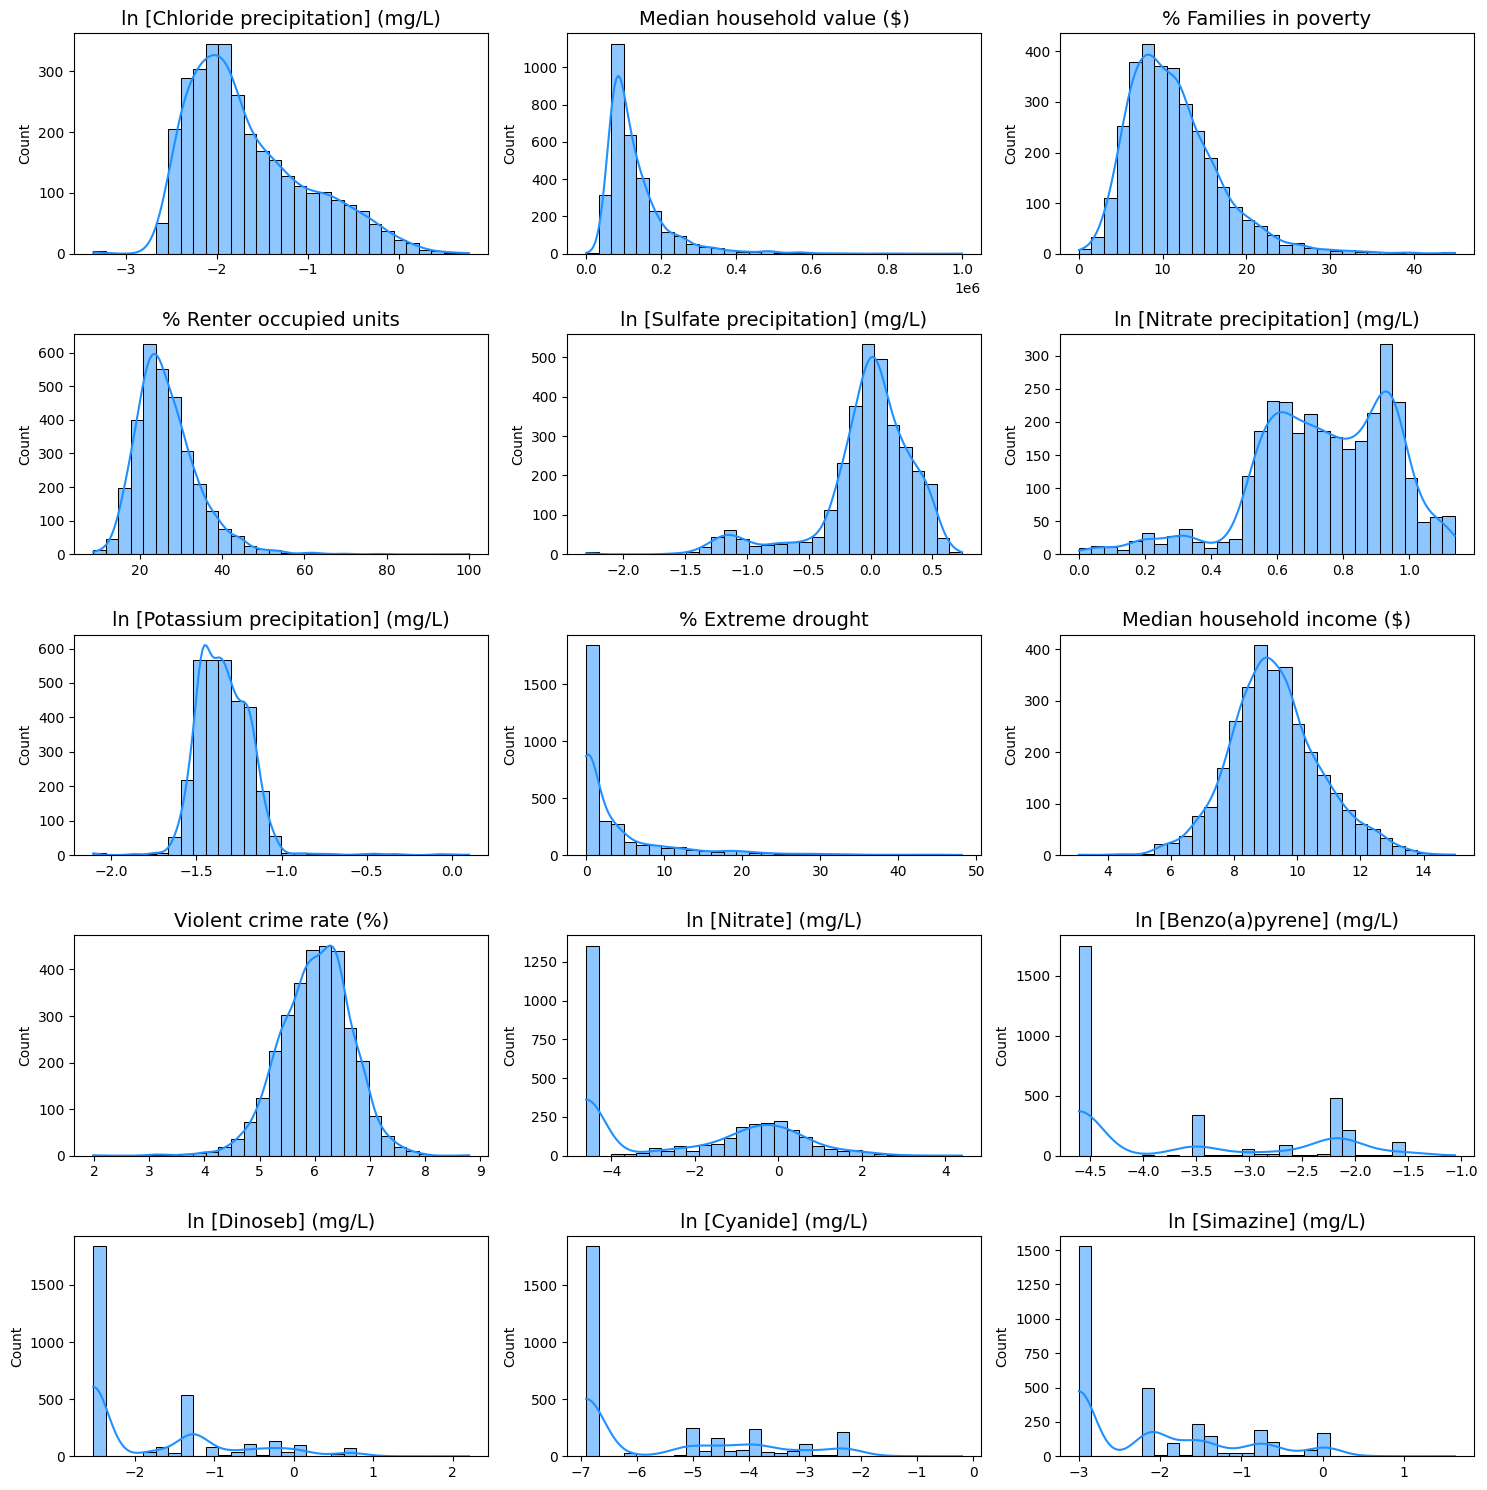

In [ ]:
# Plotting histograms to visualize distribution of selected 15 variables

# Load the dataset
df = pd.read_csv("Alzheimer_merged.csv", encoding="latin1")

# Exact column names in your file
selected_columns = [
    "Chloride precipitation ",
    "Median household value",
    "% Families in poverty",
    "% Renter occupied units",
    "Sulfate precipitation",
    "Nitrate precipitation",
    "Potassium precipitation ",
    "% Extreme drought",
    "Median household income",
    "Violent crime rate ",
    "Nitrate",
    "Benzo(a)pyrene  ",
    "Dinoseb ",
    "Cyanide ",
    "Simazine "
]

# Mapping column names to titles with units (using µ)
column_titles = {
    "Chloride precipitation ": "ln [Chloride precipitation] (mg/L)",
    "Median household value": "Median household value ($)",
    "% Families in poverty": "% Families in poverty",
    "% Renter occupied units": "% Renter occupied units",
    "Sulfate precipitation": "ln [Sulfate precipitation] (mg/L)",
    "Nitrate precipitation": "ln [Nitrate precipitation] (mg/L)",
    "Potassium precipitation ": "ln [Potassium precipitation] (mg/L)",
    "% Extreme drought": "% Extreme drought",
    "Median household income": "Median household income ($)",
    "Violent crime rate ": "Violent crime rate (%)",
    "Nitrate": "ln [Nitrate] (mg/L)",
    "Benzo(a)pyrene  ": "ln [Benzo(a)pyrene] (mg/L)",
    "Dinoseb ": "ln [Dinoseb] (mg/L)",
    "Cyanide ": "ln [Cyanide] (mg/L)",
    "Simazine ": "ln [Simazine] (mg/L)"
}

# Create histograms
n_cols = 3
n_rows = (len(selected_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

for ax, col in zip(axes.flat, selected_columns):
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color="dodgerblue")
    ax.set_title(column_titles[col], fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Count")

# Hide any empty subplots
for i in range(len(selected_columns), n_rows * n_cols):
    fig.delaxes(axes.flat[i])

plt.tight_layout()

# Save as TIFF with 600 dpi
fig.savefig("predictors_histograms.png", dpi=300, format="png")

plt.show()
